Error minimizing using different values of angle per increment for each encoder

In [380]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
# from support.omniwheel_calculation_pd import *
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from support.imu_calculations import *

# %matplotlib widget
# import ipywidgets as widgets


In [381]:
_parent_folder = "omni_9dof_may_3_2023"
_folder_name = "sk35_00_random_01"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.dirname(_base_pth)
_base_pth = os.path.join(_base_pth,"recording_programs", "test_data", _parent_folder)
_base_pth

# C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_9dof_april_20_2023\sk32_00_test_slow_00\imu01.csv

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\omni_9dof_may_3_2023'

In [382]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  _sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = -_sk_df["e_rl"]

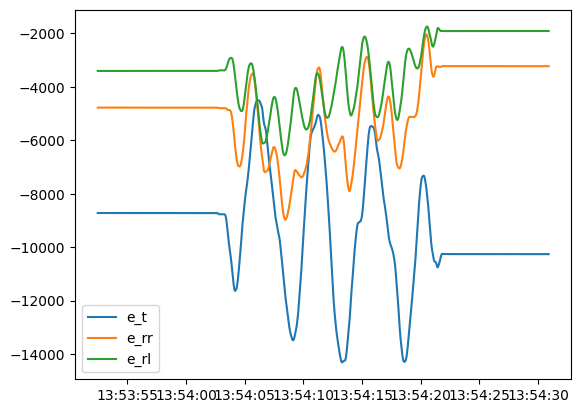

In [383]:
plt.plot(_sk_df["time"], _sk_df["e_t"], label="e_t")
plt.plot(_sk_df["time"], _sk_df["e_rr"], label="e_rr")
plt.plot(_sk_df["time"], _sk_df["e_rl"], label="e_rl")
plt.legend()


In [384]:
y = (19.7/2)/100 # meters
x = 18.5/200 # meters
radius = 5.5/200 # meters

df = _sk_df
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.15, del_t=0.01)

df, vel_col = get_directional_velocity(df, ang_col, radius=radius, x = x, y = y)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)

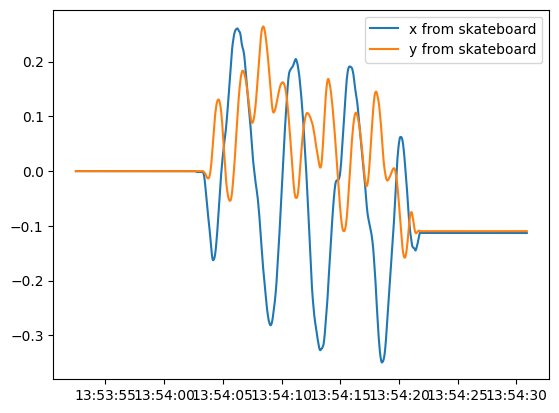

In [385]:
plt.plot(df["time"], df["x"], label="x from skateboard")
plt.plot(df["time"], df["y"], label="y from skateboard")
plt.legend()
# plt.plot(df["time"], df["theta"], label="e_rl")

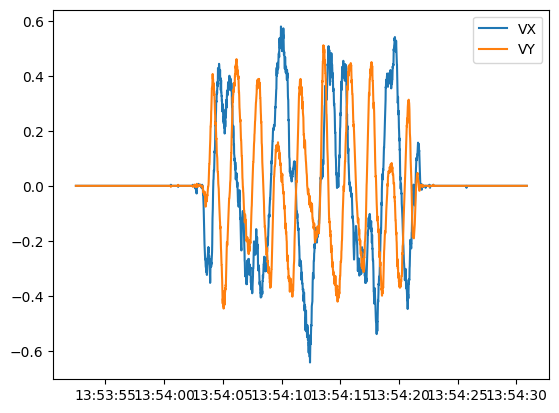

In [386]:
plt.plot(df["time"], df["vx"], label="VX")
plt.plot(df["time"], df["vy"], label="VY")
plt.legend()

In [387]:
sk_df = df[["time", "e_t", "e_rr", "e_rl"]]

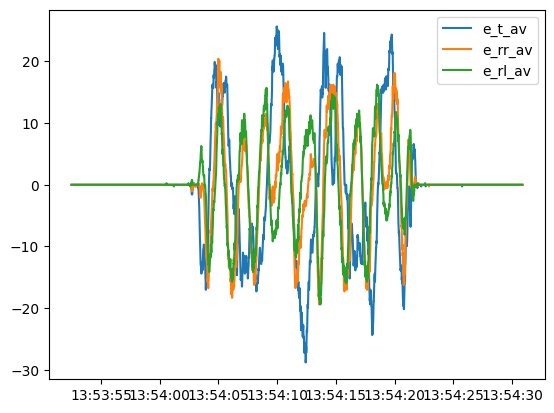

In [388]:
plt.plot(df["time"], df["e_t_av"], label="e_t_av")
plt.plot(df["time"], df["e_rr_av"], label="e_rr_av")
plt.plot(df["time"], df["e_rl_av"], label="e_rl_av")
plt.legend()

In [389]:
# type in marker details sk35
_xm = get_marker_name(1)
_ym = get_marker_name(4)
_om = get_marker_name(3)

In [390]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [391]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [392]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]


In [393]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 3368/3368 [00:00<00:00, 3641.08it/s]


In [394]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 3368/3368 [00:00<00:00, 168400.16it/s]


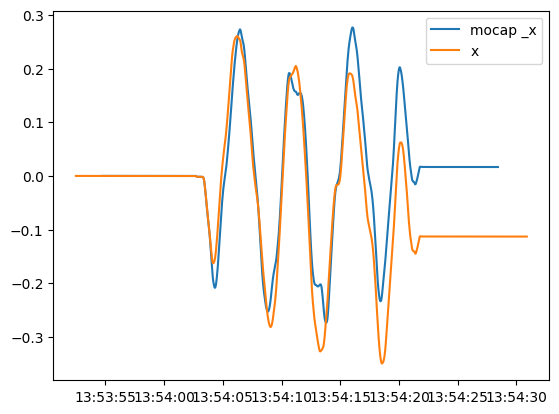

In [395]:
plt.plot(_m_df["time"], _mc_df["x"], label="mocap _x")
plt.plot(df["time"], df["x"], label="x")
plt.legend()

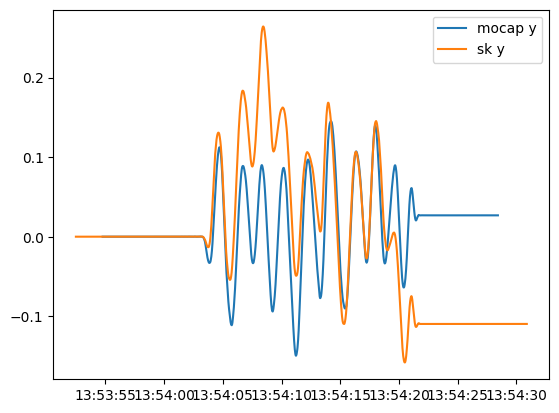

In [396]:
plt.plot(_m_df["time"], _mc_df["y"], label="mocap y")
plt.plot(df["time"], df["y"], label="sk y")
plt.legend()
# df.columns

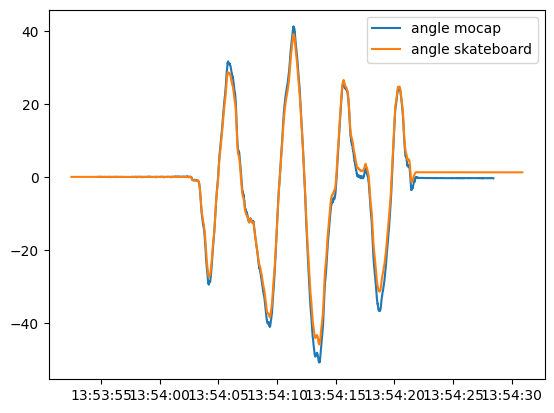

In [397]:
plt.plot(_m_df["time"], _theta_z, label="angle mocap")
plt.plot(df["time"], -np.rad2deg(df["theta"]), label="angle skateboard")
plt.legend()

In [426]:
def get_dir_vel2(df, ang_col, radius=radius, x = x, y = y,  mocap_ang= None):

    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False 

    column_name = ang_col
    print(column_name)
    my_dict = {"_vx":[],"_vy":[],"_w":[]}

    for i in range(len(df)):

        mat = np.array([[1, 0, 0],
                        [0, np.cos(mocap_ang[i]), -np.sin(mocap_ang[i])],
                        [0, np.sin(mocap_ang[i]), np.cos(mocap_ang[i])]]) # matrix for calculating the directional velocity

        pmat = np.linalg.pinv(mat)
        val = df[column_name][i].to_numpy().reshape(3,1)
        res = np.dot(pmat, val) * radius

        my_dict["_w"].append(res[0][0])
        my_dict["_vx"].append(res[1][0])
        my_dict["_vy"].append(res[2][0])


    # add the calculated values to the dataframe
    df = df.with_columns([pl.Series(name = "vx2", values = my_dict["_vx"]),
                        pl.Series(name = "vy2", values = my_dict["_vy"]),
                            pl.Series(name = "w2", values = my_dict["_w"])])
    
    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()

    return df, df.columns

def get_position2(df, dt = 0.007):
    """
    Calculate the position of the robot

    df should have "vx", "vy", "w" columns to calculate the position
    """
    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False
    
    df = df.with_columns([(pl.col("vx2").cumsum() * dt).alias("x2"),
                            (pl.col("vy2").cumsum() * dt).alias("y2")])
    
    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()
    
    return df, ["x2", "y2"]

def get_orientation2(df, dt = 0.007, column_name = "w"):

    """
    Calculate the angle of the chasis, with respect to initial frame

    df should have "w" column to calculate the angle
    """
    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False

    if not column_name:
        column_name = "w2"

    # calculate the cumulative sum of the values multiplied by dt

    df = df.with_columns([(pl.col("w2").cumsum() * dt).alias("theta2")])


    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()

    return df, ["theta2"]

In [425]:
print(radius, x, y)

0.0275 0.0925 0.09849999999999999


In [438]:
_sk_transposed = df[['time', 'e_t_av', 'e_rr_av', 'e_rl_av']].copy()
col_names = ['e_t', 'e_rr', 'e_rl']
_sk_transposed, vel_col = get_dir_vel2(df, col_names, radius=radius, x = x, y = y, mocap_ang = - np.deg2rad(_imu_df["ang_z"]))
_sk_transposed, pos_col = get_position2(_sk_transposed, dt = 0.01)

['e_t', 'e_rr', 'e_rl']


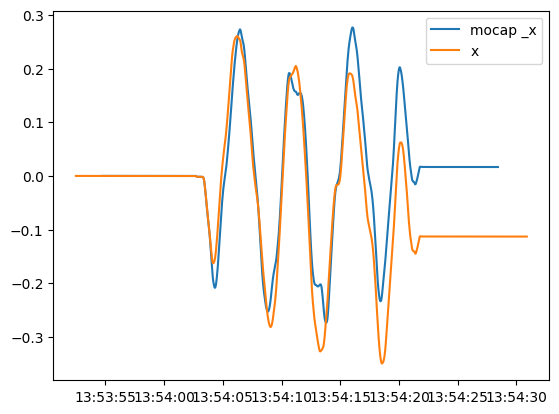

In [443]:
plt.plot(_m_df["time"], _mc_df["x"], label="mocap _x")
plt.plot(df["time"], df["x"], label="x")
# plt.plot(_sk_transposed["time"], _sk_transposed["x2"]/300, label="x")
plt.legend()

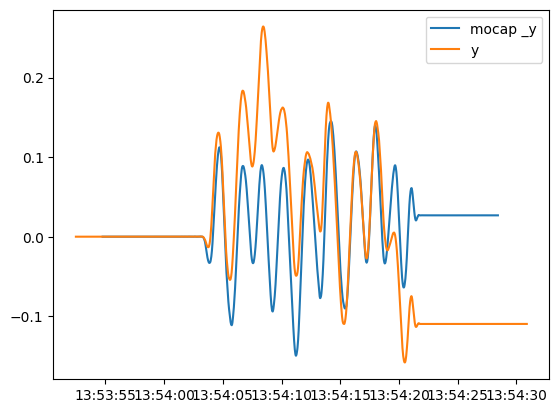

In [444]:
plt.plot(_m_df["time"], _mc_df["y"], label="mocap _y")
plt.plot(df["time"], df["y"], label="y")

# plt.plot(_sk_transposed["time"], _sk_transposed["y2"]/300, label="y")
plt.legend()

Mocap reverse

In [407]:
"""
Transforming mocap data to robot frame of reference
Computing u1, u2, u3 from mocap data
"""

_mocap_rev = _mc_df[["time",'x', 'y']].copy()
_mocap_rev["theta"] = _theta_z
_mocap_rev["vx"] = -_mocap_rev["x"].diff() / 0.01
_mocap_rev["vy"] = _mocap_rev["y"].diff() / 0.01
_mocap_rev["wx"] = -_mocap_rev["theta"].diff() / 0.01
_mocap_rev = _mocap_rev.fillna(0)


In [398]:
_imu_df = _sk_df[["time", "mils", "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz"]].copy()
_imu_df = pl.from_pandas(_imu_df)
dt = _imu_df["mils"].diff().mean()/1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter

_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])


_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

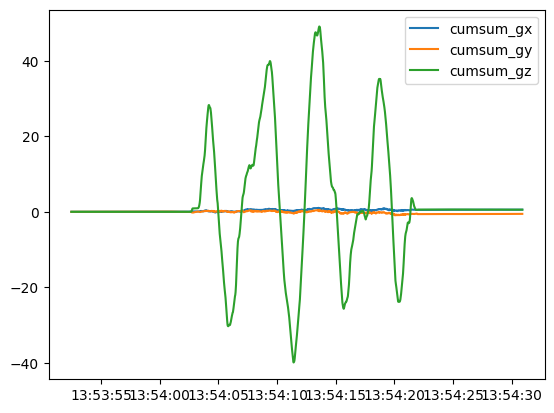

In [399]:
plt.plot(_imu_df["time"], _imu_df["ang_x"], label="cumsum_gx")
plt.plot(_imu_df["time"], _imu_df["ang_y"], label="cumsum_gy")
plt.plot(_imu_df["time"], _imu_df["ang_z"], label="cumsum_gz")
plt.legend()

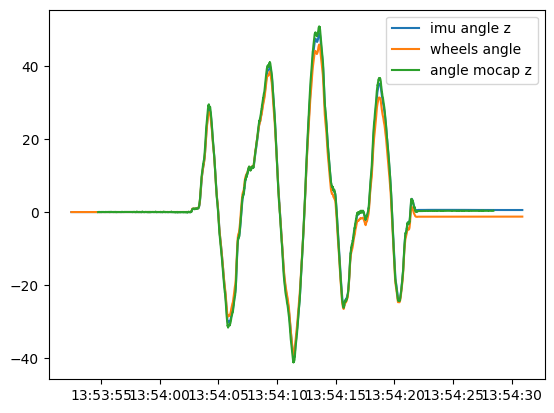

In [400]:
plt.plot(_imu_df["time"], _imu_df["ang_z"], label="imu angle z")
plt.plot(_imu_df["time"], np.rad2deg(df["theta"]), label="wheels angle")
plt.plot(_m_df["time"], -_theta_z, label="angle mocap z")
plt.legend()

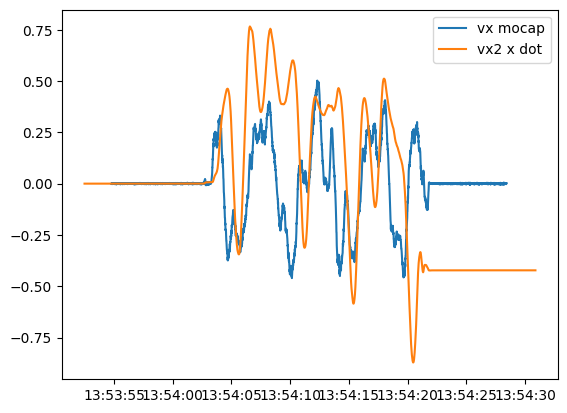

In [454]:
# plt.plot(_imu_df["time"],_imu_df["ax"].cumsum()*0.01, label="ax")
# plt.plot(_imu_df["time"], -df.vx, label="vx")
plt.plot(_mocap_rev["time"],_mocap_rev["vx"], label="vx mocap")
plt.plot(_sk_transposed["time"], -_sk_transposed["vx2"]/100, label="vx2 x dot")

plt.legend()


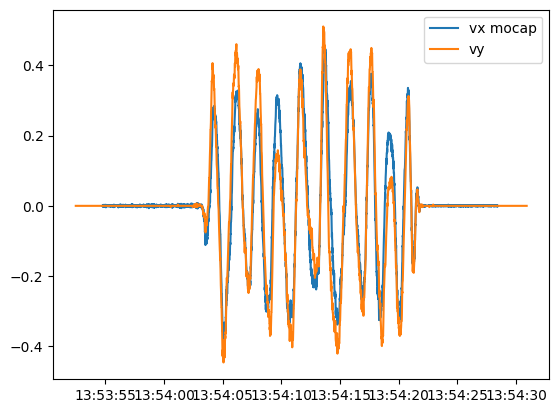

In [450]:
# plt.plot(_imu_df["ay"].cumsum()*0.01, label="ay")
plt.plot(_mocap_rev["time"], _mocap_rev["vy"], label="vx mocap")

plt.plot(_imu_df["time"], df.vy, label="vy")
plt.legend()


Combining vx from skateboard and ax from accelerometer

In [403]:
_newsk_df = df[["time", "x", "y", "theta", "vx", "vy"]].copy()
_newsk_df = pl.from_pandas(_newsk_df)
_newsk_df = _newsk_df.with_columns([
    (pl.col("vx").diff()*100).alias("ax"),
    (pl.col("vy").diff()*100).alias("ay"),
])

# apply savgol filter to ax and ay
_newsk_df = _newsk_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                    ])


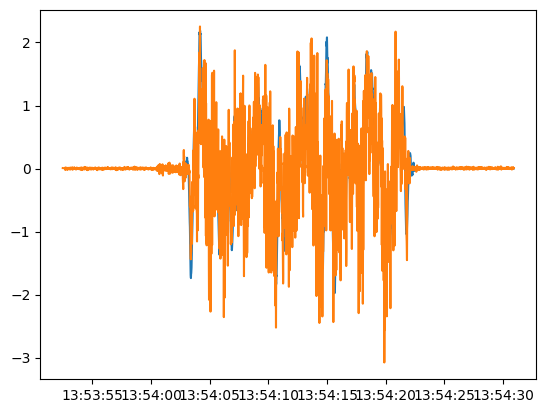

In [404]:
plt.plot(_newsk_df["time"], _newsk_df["ax"], label="ax skateboard")
plt.plot(_imu_df["time"], -_imu_df["ax"], label="ax imu")

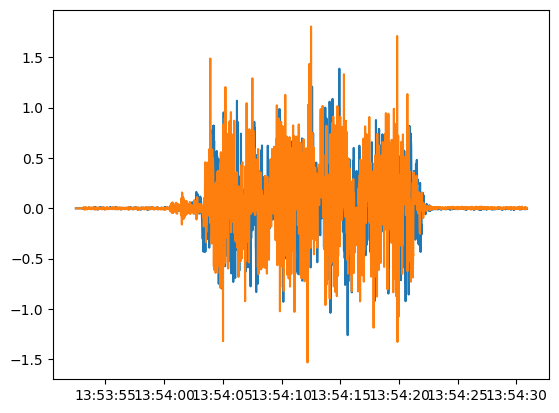

In [405]:
# compute average of ax and ay
_newsk_df = _newsk_df.with_columns([
    ((pl.col("ax") + _imu_df["ax"])/2).alias("avg_ax"),
    ((pl.col("ay") + _imu_df["ay"])/2).alias("avg_ay"),
])

_newsk_df = _newsk_df.fill_nan(0)

plt.plot(_newsk_df["time"], _newsk_df["avg_ax"], label="avg ax")
plt.plot(_newsk_df["time"], _newsk_df["avg_ay"], label="avg ay")

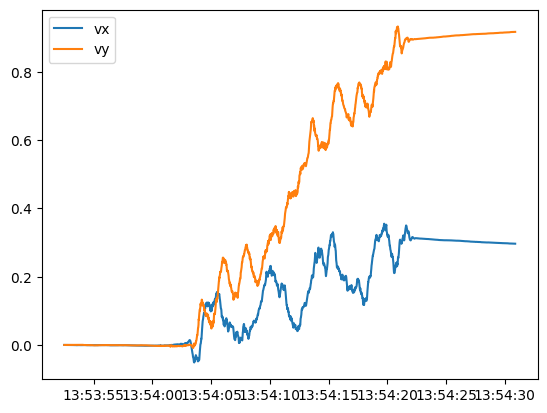

In [406]:
_new_df = _newsk_df[["time", "avg_ax", "avg_ay"]]
_new_df = _new_df.with_columns([
    (pl.col("avg_ax").cumsum()*dt).alias("vx"),
    (pl.col("avg_ay").cumsum()*dt).alias("vy"),
])

plt.plot(_new_df["time"], _new_df["vx"], label="vx")
plt.plot(_new_df["time"], _new_df["vy"], label="vy")
plt.legend()